In [1]:
import numpy as np
import pandas as pd
from IncrementalLinearGradientBooster import IncrementalLinearGradientBooster
from baseline import Baseline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
np.random.seed(2023)

In [3]:
def make_linear_data(X, Betas):
    return X@Betas + np.random.normal(size=X.shape[0])

def make_gaussian_data(X, Betas, sigma_inv=None):
    if sigma_inv is None:
        sigma_inv = np.eye(N=X.shape[1])/X.shape[1]

    res = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        val = (X[i] - Betas).T@sigma_inv@(X[i] - Betas)
        res[i] = val

    return res + np.random.normal(size=X.shape[0])

def make_circular_data(X, betas, sigma_inv=None):
    res = np.zeros(X.shape[0])
     
    for i in range(X.shape[0]):
        val = np.sum(X[i]*betas)
        val = np.log(val**2)
        print(val)
        res[i] = val
    res += np.random.normal(size=X.shape[0])
    return res

def make_poly(X, betas, sigma_inv=None):
    return betas[3]*X[:,3]**3 + X[:,3] - X[:,0]


In [4]:
order       = 3
n_samples   = 10**2
n_steps     = 500
p           = 10

X = np.random.normal(size=[n_samples, p])           # generate random X-s
Betas = np.random.normal(loc= 1,scale=3, size=[p])  # generate random coefficients
sigma_inv = np.eye(N=p)/p
sigma_inv[3,4] = 1/1000
sigma_inv[4,3] = 1/1000
sigma_inv[2,9] = 1/1000
sigma_inv[9,2] = 1/1000
y = make_poly(X, Betas, sigma_inv=sigma_inv)           # generate y-s, and add normal noise


Xtest = np.random.normal(size=[100*n_samples, p])           # generate random X-s
ytest = make_poly(Xtest, Betas, sigma_inv=sigma_inv)            # generate y-s, and add normal noise

# normalize with training data
ytest = (ytest - y.mean())/y.std()
Xtest = (Xtest - X.mean(axis=0))/X.std(axis=0)

y = (y - y.mean())/y.std()
X = (X - X.mean(axis=0))/X.std(axis=0)



In [5]:
y

array([ 0.14430407,  0.18462253,  0.21661472, -0.9665305 ,  0.5087391 ,
       -5.13916753,  0.21007614, -0.91201541,  0.57161209,  0.07557848,
       -0.89162441,  0.31472555, -0.10103344,  0.24491162,  0.27239245,
        0.0772174 ,  0.10291419, -0.21174078, -0.02366241, -0.20040583,
        0.45881496,  0.63559788,  0.04916402,  0.12278449,  0.1324    ,
        0.36967723,  0.13315852,  0.1673815 ,  0.12198127,  1.91429091,
        0.20086633, -0.21178252,  0.17999879,  0.11830314, -0.03274253,
       -3.7260408 ,  0.18639567, -3.9440334 ,  0.18348235, -0.04396677,
        0.27637529,  0.09049185,  1.03494145, -0.09252286,  0.26147237,
        0.26577531,  0.38745569,  0.21541831,  0.09352168,  0.14677274,
        0.23576206,  0.69607478, -0.03806353,  0.23226953,  0.1173747 ,
       -0.11233748,  3.90887409, -0.12447029, -0.76201414, -2.30300235,
        0.01721383,  0.08820464,  0.74589084, -1.37711989,  0.19490308,
       -0.35653464,  0.01307558,  1.09372247, -0.07992906, -0.47

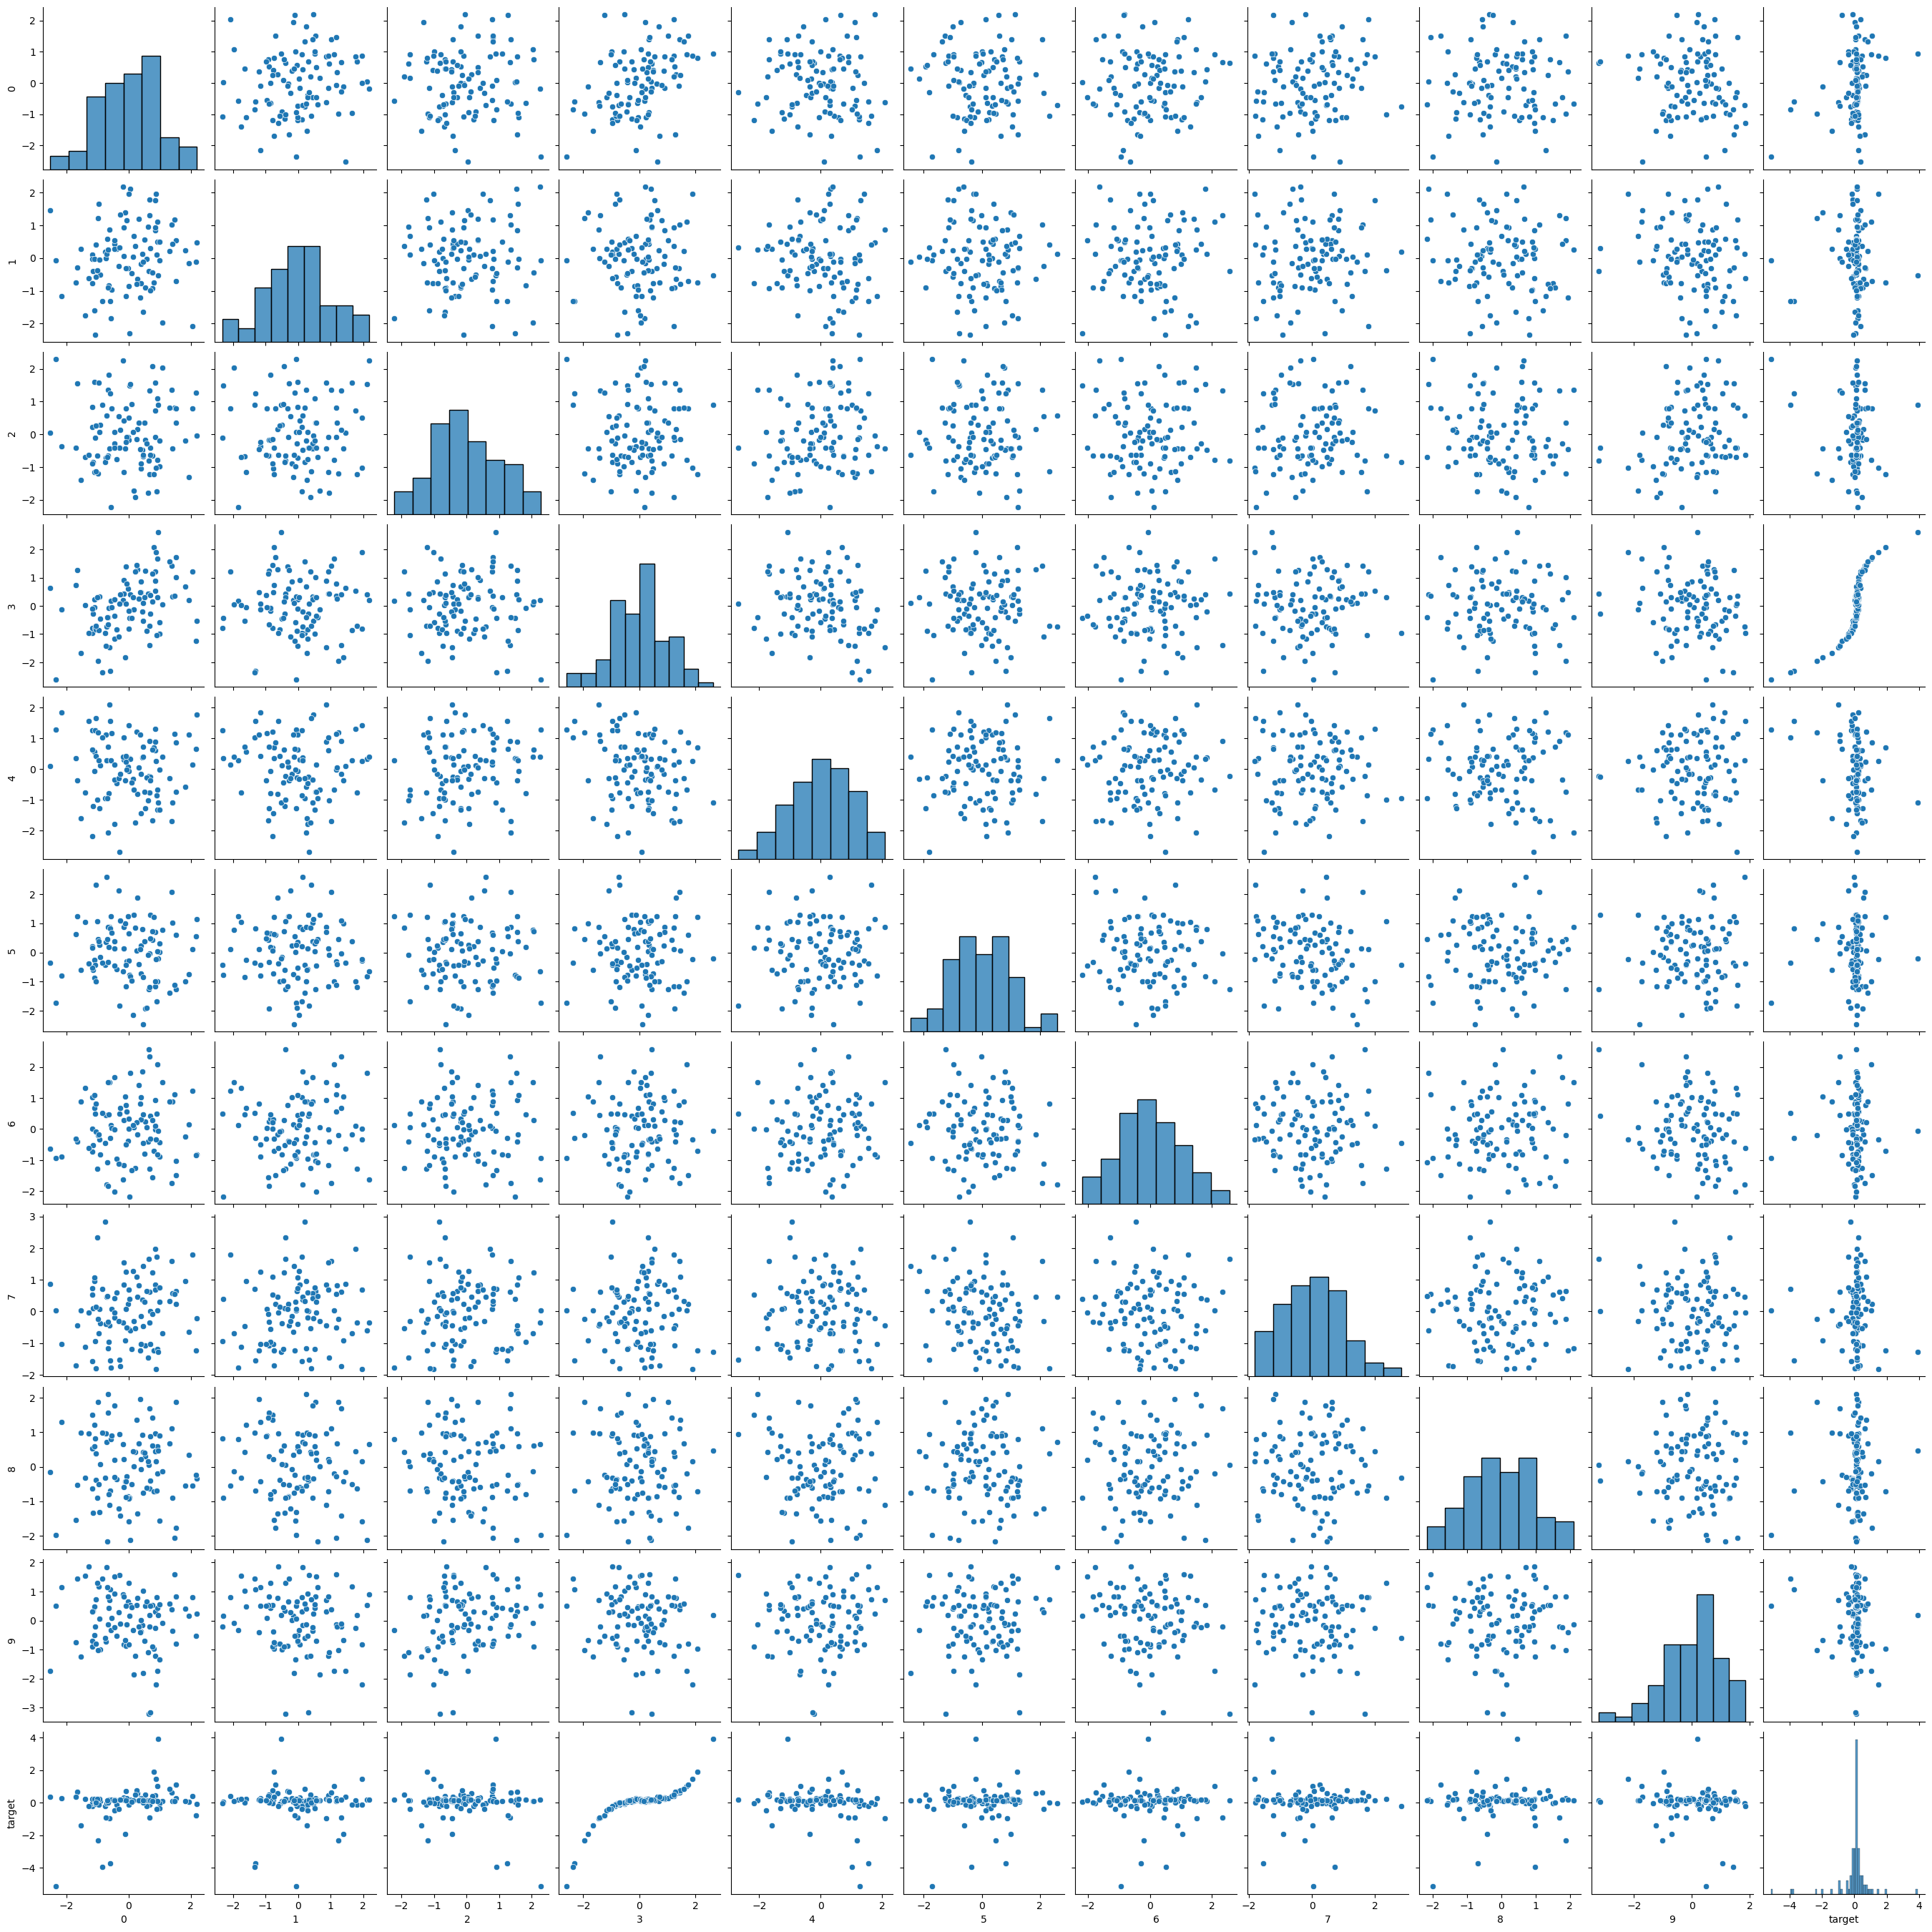

In [6]:
def make_pair_plot(X, y):
    import seaborn as sns
    df = pd.DataFrame(data=X)
    df['target']= y
    return sns.pairplot(df)

make_pair_plot(X,y)


In [7]:
# estimate coefficients
model = IncrementalLinearGradientBooster(n_steps=n_steps, order=order, gamma=0.1, verbose=True)
model.fit(X,y)

 0.00 %
 10.00 %
 20.00 %
 30.00 %
 40.00 %
 50.00 %
 60.00 %
 70.00 %
 80.00 %
 90.00 %
Done fitting [-0.04710281  0.          0.         ...  0.          0.
  0.        ]


In [8]:

def expand(X, order):
    try:
        p = len(X.columns)
    except:
        X = pd.DataFrame(X)
        p = len(X.columns)

    dfs = [X]

    for power in range(1, order):
        tmp = pd.DataFrame()
        for colname in X.columns:
            
            for df2 in dfs:
                for colname2 in df2.columns:
                    tmp[str(colname) + '_' + str(colname2)] = X[colname] * df2[colname2]
        dfs.append(tmp)
    
    return pd.concat(dfs, axis=1)

In [9]:
ols = Baseline()
ols.fit(X,y)
mse_ols_train = ((y - ols.predict(X))**2).mean()
mse_ols_test = ((ytest - ols.predict(Xtest))**2).mean()
X_df_train = pd.DataFrame(data=X)
X_df_test = pd.DataFrame(data=Xtest)

X_df_train.columns = [str(i) for i in X_df_train.columns]
X_df_test.columns = [str(i) for i in X_df_test.columns]

ols_expanded = Baseline()
ols_expanded.fit(model.get_transformed_X(), y)
mse_ols_expanded_train  = ((y - ols_expanded.predict(model.expand(X_df_train)))**2).mean()
mse_ols_expanded_test   = ((ytest - ols_expanded.predict(model.expand(X_df_test)))**2).mean()

print(mse_ols_train, mse_ols_expanded_train)
print(mse_ols_test, mse_ols_expanded_test)


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


0.3139669304076561 6.893921516142046e-30
0.6033435807766505 0.44205469643975304


/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [10]:
eps = 10**(-5)
(abs(model.trace) > eps).sum(axis=0)

array([29,  0,  0, ...,  0,  0,  0])

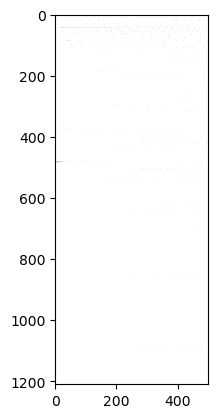

In [11]:
plt.imshow(abs(model.trace.T)<eps, cmap='gray')

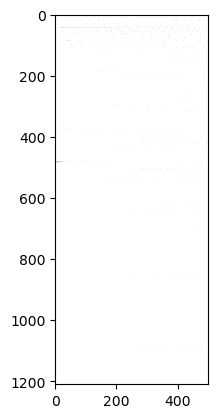

In [12]:
plt.imshow(model.trace.T==0, cmap='gray')

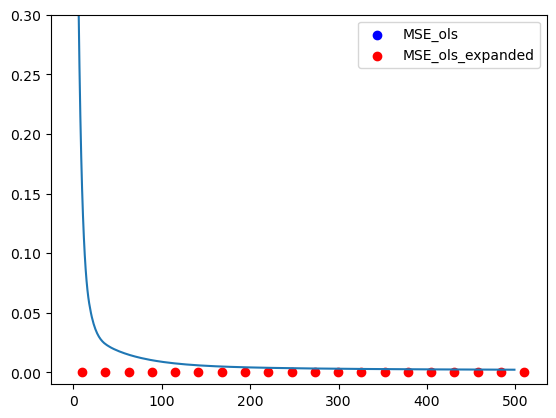

In [13]:
n_samples_for_scatter = 20
plt.plot(range(n_steps), model.trace_loss(X, y))
plt.scatter(np.linspace(0,n_steps, n_samples_for_scatter), [mse_ols_train]*n_samples_for_scatter, label = 'MSE_ols', color='b')
plt.scatter(np.linspace(n_samples_for_scatter/2, n_steps + n_samples_for_scatter/2, n_samples_for_scatter ), [mse_ols_expanded_train]*n_samples_for_scatter, label = 'MSE_ols_expanded', color='r')
plt.ylim([-0.01, 0.3])
plt.legend()

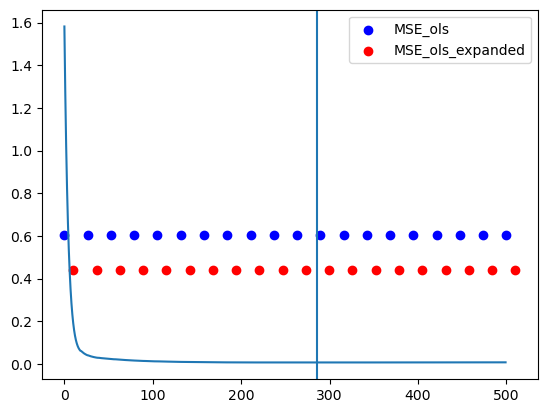

In [14]:
tl = model.trace_loss(Xtest, ytest)
plt.plot( range(len(model.trace_loss(X, y))), tl)
plt.scatter(np.linspace(0,n_steps, n_samples_for_scatter), [mse_ols_test]*n_samples_for_scatter, label = 'MSE_ols', color='b')
plt.scatter(np.linspace(n_samples_for_scatter/2, n_steps + n_samples_for_scatter/2, n_samples_for_scatter ), [mse_ols_expanded_test]*n_samples_for_scatter, label = 'MSE_ols_expanded', color='r')
plt.axvline(np.argmin(tl))
plt.legend()

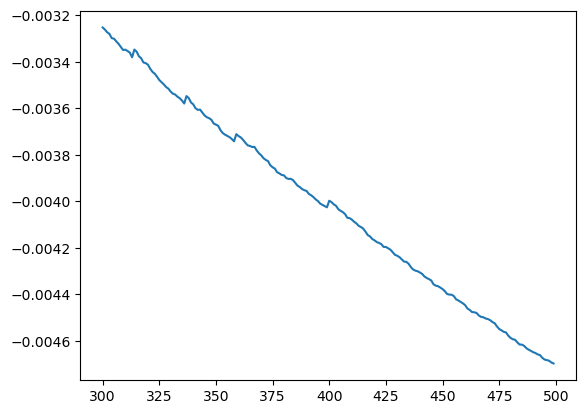

In [15]:
start = 300
plt.plot(range(len(model.trace_loss(X, y)))[start:], np.array(model.trace_loss(X, y))[start:] - np.array(model.trace_loss(Xtest, ytest))[start:])

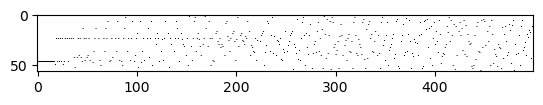

In [19]:
selected_columns = set(np.argmax(step != 0) for step in model.trace)
len(selected_columns)

traces = np.array([model.trace[:500,i] for i in selected_columns])
plt.imshow(traces==0, cmap='gray')